# Proyecto - Etapa 3

In [1]:
import pandas as pd
import numpy as np
import missingno as msngo
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
import seaborn as sns

#Evitar avisos de deprecación entre otros.
import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
 
from pylab import rcParams
 
from collections import Counter

# Carga de datos

In [2]:
datos = pd.read_excel("Diplomado_DS_Proyecto.xlsx")
#datos
datos["INGRESO_BRUTO_FAMILIAR"].info() #str en R
#datos.describe() #summary en R


<class 'pandas.core.series.Series'>
RangeIndex: 2143 entries, 0 to 2142
Series name: INGRESO_BRUTO_FAMILIAR
Non-Null Count  Dtype  
--------------  -----  
1761 non-null   float64
dtypes: float64(1)
memory usage: 16.9 KB


In [3]:
datos["INGRESO_BRUTO_FAMILIAR"].isna().value_counts()

False    1761
True      382
Name: INGRESO_BRUTO_FAMILIAR, dtype: int64

In [4]:
datos["INGRESO_BRUTO_FAMILIAR"].notnull().value_counts()

True     1761
False     382
Name: INGRESO_BRUTO_FAMILIAR, dtype: int64

In [5]:
#Análisis de variable respuesta
print(datos['SE_MATRICULA'].value_counts(normalize=True))
#print(datos['PROMEDIO_ALUMNO_EN_CARRERA'].value_counts(normalize=True))


1    0.881008
0    0.118992
Name: SE_MATRICULA, dtype: float64


In [6]:
print(datos.isnull().sum(axis=0))

IDENTIFICADOR                    0
RUT_ENMASCARADO                  0
PERS_SEXO                        0
FNACIMIENTO                     13
EDAD                            49
                                ..
TIENE_GRATUIDAD                  0
TIENE_BENEFICIO_ALIMENTACION     0
CANT_COLACIONES                  0
CANT_ALMUERZOS                   0
CANT_CENAS                       0
Length: 76, dtype: int64


## Filtro y modificación datos

In [7]:
# Corresponde que estos casos particulares estén matriculados, no estaban
# matriculados porque venían de bachilleraro o traslado.
datos['SE_MATRICULA'] = np.where( (datos['SE_MATRICULA']==0) &\
     (datos['ANNIO_INGRESO'] == datos['ANNIO_MATRICULA_INDICE']),1,datos['SE_MATRICULA'])

display(datos['SE_MATRICULA'].value_counts(normalize=True))

1    0.887074
0    0.112926
Name: SE_MATRICULA, dtype: float64

In [8]:
#Filtra estudiantes sin notas en carrera
datos = datos.query("PROMEDIO_ALUMNO_EN_CARRERA != 0") 
#display(datos['PROMEDIO_ALUMNO_EN_CARRERA'].value_counts(normalize=True))

datos.info()

#Otra forma de Filtro
#filtro_sin_notas = datos['PROMEDIO_ALUMNO_EN_CARRERA'] != 0
#datos = datos[filtro_sin_notas]
#datos.describe(include = np.number)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2093 entries, 0 to 2142
Data columns (total 76 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   IDENTIFICADOR                      2093 non-null   int64  
 1   RUT_ENMASCARADO                    2093 non-null   int64  
 2   PERS_SEXO                          2093 non-null   object 
 3   FNACIMIENTO                        2080 non-null   object 
 4   EDAD                               2044 non-null   float64
 5   COD_NACIONLD                       2076 non-null   float64
 6   CODUA                              2093 non-null   int64  
 7   CODPLAN                            2093 non-null   int64  
 8   CARR_DESCRIPCION                   2093 non-null   object 
 9   FACULTAD                           2093 non-null   object 
 10  ANNIO_INGRESO                      2093 non-null   int64  
 11  SEME_INICIO                        2093 non-null   int64

In [9]:
## quitando 3 ruts duplicados -----
# Habría que ver como tratarlos, entraron 2 veces a la misma carrera
filtro_duplicados = (datos['RUT_ENMASCARADO'] != 21001132) & (datos['RUT_ENMASCARADO'] != 20024046) &\
                    (datos['RUT_ENMASCARADO'] != 20268182) 
datos = datos[filtro_duplicados]
datos.info()
#datos.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2076 entries, 0 to 2142
Data columns (total 76 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   IDENTIFICADOR                      2076 non-null   int64  
 1   RUT_ENMASCARADO                    2076 non-null   int64  
 2   PERS_SEXO                          2076 non-null   object 
 3   FNACIMIENTO                        2063 non-null   object 
 4   EDAD                               2027 non-null   float64
 5   COD_NACIONLD                       2059 non-null   float64
 6   CODUA                              2076 non-null   int64  
 7   CODPLAN                            2076 non-null   int64  
 8   CARR_DESCRIPCION                   2076 non-null   object 
 9   FACULTAD                           2076 non-null   object 
 10  ANNIO_INGRESO                      2076 non-null   int64  
 11  SEME_INICIO                        2076 non-null   int64

In [10]:
# cantidad de registros con la condición
datos.query("SE_MATRICULA==1")['RUT_ENMASCARADO'].count()

1869

In [11]:
datos["SE_MATRICULA_N"]=np.where((datos["SE_MATRICULA"]==1) & (datos["CANT_RETIROS_TEMPORALES"]==2),0,datos["SE_MATRICULA"])

## Agrupación de datos por rut

In [12]:
# agrupa por rut, sin considerar matricula
# retiro temporal por semestre
# datos_group2 <- datos %>% 
#  group_by(RUT_ENMASCARADO) %>% 
#  summarise(nro_ret_temp= sum(CANT_RETIROS_TEMPORALES)/2, 
#  .groups ="drop")

#datos agrupados por rut
datos_group = datos.groupby("RUT_ENMASCARADO")

# suma cant. retiros temporales y divide por 2 (son semestrales)
datos_group = datos_group.agg({ "CANT_RETIROS_TEMPORALES" : "sum" })
datos_group["nro_ret_temp"] = datos_group["CANT_RETIROS_TEMPORALES"]/2
datos_group = datos_group.drop(columns="CANT_RETIROS_TEMPORALES")
datos_group

,nro_ret_temp
RUT_ENMASCARADO,
14792234,0.0
15256444,0.0
15734102,0.0
15950623,0.5
16190380,0.0
...,...
25728092,0.0
25943007,0.0
26034894,0.0


In [13]:
#datos_group = summarise(nro_anioMat=n(), 
#            tot_anioMat = (2021 - min(ANNIO_INGRESO)+1),
#            .groups ="drop")

# agrupando los datos que tienen matricula
matriculados = datos.query("SE_MATRICULA_N==1") 

#datos agrupados por rut, matriculados
matr_group = matriculados.groupby('RUT_ENMASCARADO').agg({  "IDENTIFICADOR" : "count",
                                                          "ANNIO_INGRESO" : "min" })
matr_group["nro_anioMat"] = matr_group["IDENTIFICADOR"]
matr_group["tot_anioMat"] = 2021 - matr_group["ANNIO_INGRESO"] + 1
#matr_group.query("nro_anioMat != tot_anioMat")

matr_group = matr_group.drop(columns=["IDENTIFICADOR","ANNIO_INGRESO"])
matr_group 


,nro_anioMat,tot_anioMat
RUT_ENMASCARADO,,
14792234,4,4
15256444,3,3
15734102,4,4
15950623,1,5
16190380,5,5
...,...,...
25728092,1,1
25943007,2,2
26034894,2,2


In [14]:
# calcula variable DESERTA en base a matriculados y retiros temporales
#datos_group <- datos_group %>% 
#  mutate ( matr_y_retiro = tot_anioMat-(nro_anioMat+nro_ret_temp),
#    DESERTA = ifelse(matr_y_retiro<=0,0,1))

# mezcla 2 grupos anteriores
datos_matr_group = pd.merge(datos_group,matr_group,left_on='RUT_ENMASCARADO', right_on='RUT_ENMASCARADO')#.drop('Empleado', axis = 1) 
datos_matr_group["DESERTA"] = np.where(datos_matr_group["tot_anioMat"]-(datos_matr_group["nro_anioMat"]+datos_matr_group["nro_ret_temp"])<=0,0,1)
datos_matr_group = datos_matr_group.drop(columns=["nro_ret_temp","nro_anioMat","tot_anioMat"])
datos_matr_group

,DESERTA
RUT_ENMASCARADO,
14792234,0
15256444,0
15734102,0
15950623,1
16190380,0
...,...
25728092,0
25943007,0
26034894,0


## Mezcla data con datos agrupados

In [15]:
# mezcla completa
datos_merge = pd.merge(datos,datos_matr_group,left_on='RUT_ENMASCARADO', right_on='RUT_ENMASCARADO')#.drop('RUT_ENMASCARADO', axis = 1) 
datos_merge

,IDENTIFICADOR,RUT_ENMASCARADO,PERS_SEXO,FNACIMIENTO,EDAD,COD_NACIONLD,CODUA,CODPLAN,CARR_DESCRIPCION,FACULTAD,...,CANT_RAMOS_OP2,CANT_RAMOS_OP3,CANT_RAMOS_OP4,TIENE_GRATUIDAD,TIENE_BENEFICIO_ALIMENTACION,CANT_COLACIONES,CANT_ALMUERZOS,CANT_CENAS,SE_MATRICULA_N,DESERTA
0,1479223433532018,14792234,F,1999-11-04 00:00:00,22.0,1.0,3353,3,3353- INGENIERIA COMERCIAL MENCION NEGOCIOS MI...,FACULTAD DE INGENIERIA,...,2,0,0,1,0,0,0,0,1,0
1,1479223433532018,14792234,F,1999-11-04 00:00:00,22.0,1.0,3353,3,3353- INGENIERIA COMERCIAL MENCION NEGOCIOS MI...,FACULTAD DE INGENIERIA,...,2,0,0,1,0,0,0,0,1,0
2,1479223433532018,14792234,F,1999-11-04 00:00:00,22.0,1.0,3353,3,3353- INGENIERIA COMERCIAL MENCION NEGOCIOS MI...,FACULTAD DE INGENIERIA,...,2,0,0,1,0,0,0,0,1,0
3,1479223433532018,14792234,F,1999-11-04 00:00:00,22.0,1.0,3353,3,3353- INGENIERIA COMERCIAL MENCION NEGOCIOS MI...,FACULTAD DE INGENIERIA,...,2,0,0,1,0,0,0,0,1,0
4,1525644433532019,15256444,F,2000-11-06 00:00:00,21.0,1.0,3353,3,3353- INGENIERIA COMERCIAL MENCION NEGOCIOS MI...,FACULTAD DE INGENIERIA,...,1,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2071,2594300733532020,25943007,M,2001-12-16 00:00:00,20.0,2.0,3353,3,3353- INGENIERIA COMERCIAL MENCION NEGOCIOS MI...,FACULTAD DE INGENIERIA,...,5,0,0,1,0,0,0,0,1,0
2072,2603489433532020,26034894,F,2001-11-09 00:00:00,20.0,2.0,3353,3,3353- INGENIERIA COMERCIAL MENCION NEGOCIOS MI...,FACULTAD DE INGENIERIA,...,0,0,0,1,0,0,0,0,1,0
2073,2603489433532020,26034894,F,2001-11-09 00:00:00,20.0,2.0,3353,3,3353- INGENIERIA COMERCIAL MENCION NEGOCIOS MI...,FACULTAD DE INGENIERIA,...,0,0,0,1,0,0,0,0,1,0
2074,2627009333532021,26270093,F,2002-12-20 00:00:00,19.0,2.0,3353,3,3353- INGENIERIA COMERCIAL MENCION NEGOCIOS MI...,FACULTAD DE INGENIERIA,...,0,0,0,1,0,0,0,0,1,0


## Limpieza de la mezcla

In [16]:
# limpieza de la mezcla 
datos_clean = datos_merge.drop(columns=["CODPLAN", "SE_MATRICULA",
           "ANNIO_MATRICULA_INDICE", "PROM_NOTA_SEM1", "PROM_NOTA_SEM2",
            "NUMEROCURSOSAPROBADOS_S1", "NUMEROCURSOSAPROBADOS_S2",
            "NUMEROCURSOSINSCRITOS_S1", "NUMEROCURSOSINSCRITOS_S2",
            "IDENTIFICADOR", "FNACIMIENTO", "CARR_DESCRIPCION", "FACULTAD",
            "COD_ESTADO_PLAN", "ESTADO_PLAN_TEXTO", "AGNO_PROCESO","PROMEDIO_ANUAL",
            "SEME_INICIO", "PERS_COMENTARIO", "FACTUAL","DEUDA_DAA",#"ANNIO_INGRESO"
            "TOTAL_DEUDA", "CANT_RETIROS_TEMPORALES", "CANT_ALMUERZOS", "DEUDA_DAA",
            "CANT_DEUDAS_DISTINTAS_EN_EL_ANNIO", "TIENE_BENEFICIO_ALIMENTACION",
            "DEUDA_ARA", "DEUDA_MAT", "DEUDA_COB", "DEUDA_CUA", 
            "TIENE_DEUDA_ARA", "TIENE_DEUDA_DAA", "TIENE_DEUDA_MAT","TIENE_GRATUIDAD",
            "TIENE_DEUDA_COB", "TIENE_DEUDA_CUA", "CANT_COLACIONES", "CANT_CENAS","SE_MATRICULA_N" ]) # con una sola categoria (0)

datos_clean.to_csv('datos_clean.csv')

datos_clean


,RUT_ENMASCARADO,PERS_SEXO,EDAD,COD_NACIONLD,CODUA,ANNIO_INGRESO,RAMA_EDUCACIONAL,REGION_ESTAB_EDUC,PROVINCIA_ESTAB_EDUC,COMUNA_ESTAB_EDUC,...,PROMEDIO_PRIMER_ANNIO,PROMEDIO_ALUMNO_EN_CARRERA,CANT_RAMOS_INSCRITOS_CARRERA,CANT_RAMOS_APROBADOS_CARRERA,CANT_RAMOS_PLAN_CARRERA,PORCENTAJE_AVANCE_CARRERA,CANT_RAMOS_OP2,CANT_RAMOS_OP3,CANT_RAMOS_OP4,DESERTA
0,14792234,F,22.0,1.0,3353,2018,H1,REGION DE ANTOFAGASTA,ANTOFAGASTA,ANTOFAGASTA,...,4.73,5.44,48,46,56,82.14,2,0,0,0
1,14792234,F,22.0,1.0,3353,2018,H1,REGION DE ANTOFAGASTA,ANTOFAGASTA,ANTOFAGASTA,...,4.73,5.44,48,46,56,82.14,2,0,0,0
2,14792234,F,22.0,1.0,3353,2018,H1,REGION DE ANTOFAGASTA,ANTOFAGASTA,ANTOFAGASTA,...,4.73,5.44,48,46,56,82.14,2,0,0,0
3,14792234,F,22.0,1.0,3353,2018,H1,REGION DE ANTOFAGASTA,ANTOFAGASTA,ANTOFAGASTA,...,4.73,5.44,48,46,56,82.14,2,0,0,0
4,15256444,F,21.0,1.0,3353,2019,T3,REGION DE ANTOFAGASTA,ANTOFAGASTA,ANTOFAGASTA,...,4.84,5.06,36,32,56,57.14,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2071,25943007,M,20.0,2.0,3353,2020,H1,REGION DE ANTOFAGASTA,ANTOFAGASTA,ANTOFAGASTA,...,1.00,1.30,12,1,56,1.79,5,0,0,0
2072,26034894,F,20.0,2.0,3353,2020,T1,REGION DE ANTOFAGASTA,ANTOFAGASTA,ANTOFAGASTA,...,5.35,5.21,24,21,56,37.50,0,0,0,0
2073,26034894,F,20.0,2.0,3353,2020,T1,REGION DE ANTOFAGASTA,ANTOFAGASTA,ANTOFAGASTA,...,5.35,5.21,24,21,56,37.50,0,0,0,0
2074,26270093,F,19.0,2.0,3353,2021,H1,REGION DE ANTOFAGASTA,ANTOFAGASTA,ANTOFAGASTA,...,4.28,4.28,13,12,56,21.43,0,0,0,0


## Quitar duplicados

In [19]:
# # quitar duplicados
datos_clean2 =datos_clean[~datos_clean.duplicated()]
datos_clean2.info()

# quitar duplicados
#datos_clean2 =datos_merge[~datos_merge.duplicated()]
#datos_clean2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 633 entries, 0 to 2075
Data columns (total 39 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   RUT_ENMASCARADO               633 non-null    int64  
 1   PERS_SEXO                     633 non-null    object 
 2   EDAD                          618 non-null    float64
 3   COD_NACIONLD                  629 non-null    float64
 4   CODUA                         633 non-null    int64  
 5   ANNIO_INGRESO                 633 non-null    int64  
 6   RAMA_EDUCACIONAL              566 non-null    object 
 7   REGION_ESTAB_EDUC             567 non-null    object 
 8   PROVINCIA_ESTAB_EDUC          567 non-null    object 
 9   COMUNA_ESTAB_EDUC             412 non-null    object 
 10  BEA                           53 non-null     object 
 11  DIR_REGION                    461 non-null    object 
 12  DIR_PROVINCIA                 461 non-null    object 
 13  DIR_

Bajar la data

In [21]:
datos_clean2[datos_clean2["RUT_ENMASCARADO"]==18289782].isna()

,RUT_ENMASCARADO,PERS_SEXO,EDAD,COD_NACIONLD,CODUA,ANNIO_INGRESO,RAMA_EDUCACIONAL,REGION_ESTAB_EDUC,PROVINCIA_ESTAB_EDUC,COMUNA_ESTAB_EDUC,...,PROMEDIO_PRIMER_ANNIO,PROMEDIO_ALUMNO_EN_CARRERA,CANT_RAMOS_INSCRITOS_CARRERA,CANT_RAMOS_APROBADOS_CARRERA,CANT_RAMOS_PLAN_CARRERA,PORCENTAJE_AVANCE_CARRERA,CANT_RAMOS_OP2,CANT_RAMOS_OP3,CANT_RAMOS_OP4,DESERTA
62,False,False,True,False,False,False,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False


## Revisión de NAs

Visualización de NAs

<AxesSubplot:>

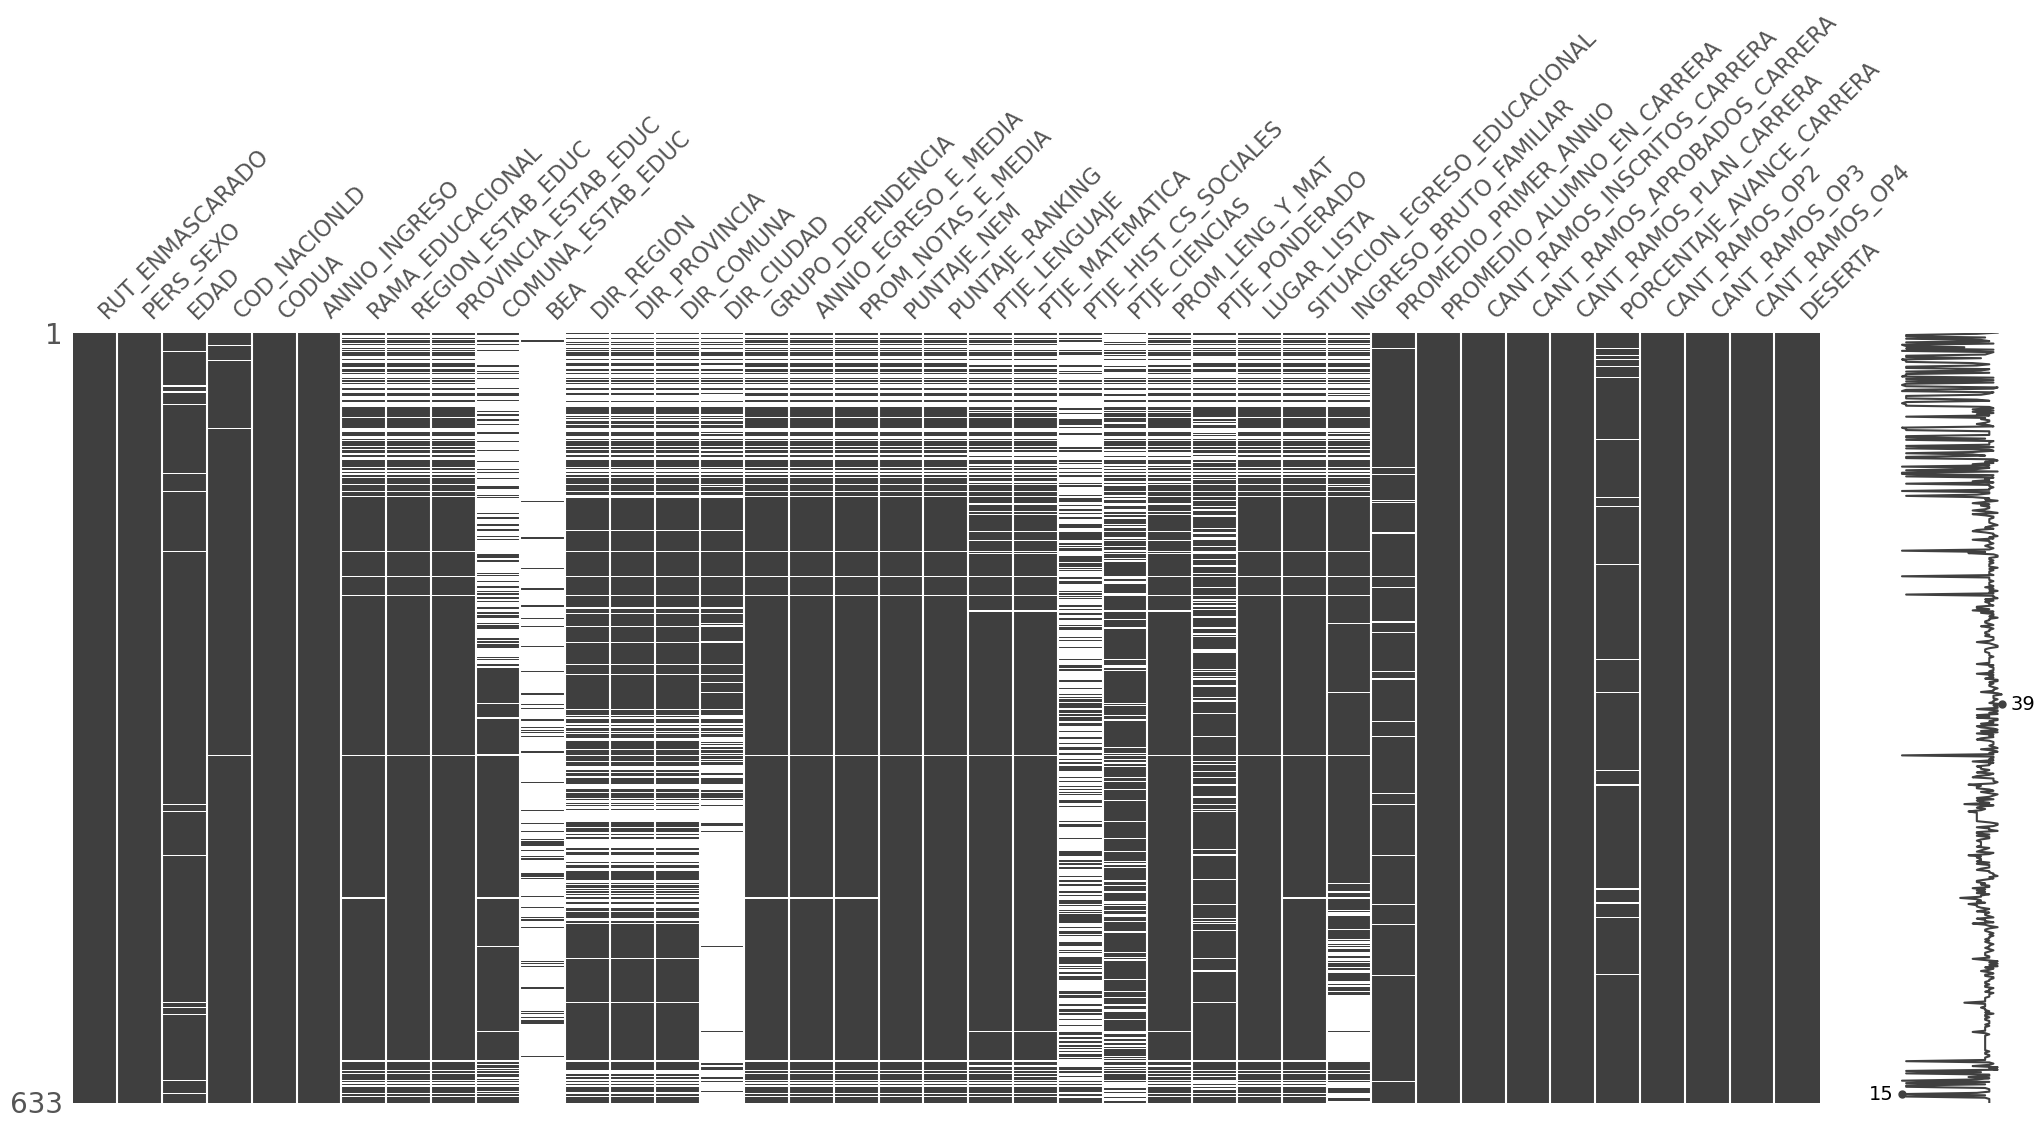

In [22]:
msngo.matrix(datos_clean2)

Eliminación variables con demasiados NAs

In [23]:
datos_clean2 = datos_clean2.drop(columns=["DIR_CIUDAD","COMUNA_ESTAB_EDUC","LUGAR_LISTA",\
"DIR_REGION","DIR_COMUNA","DIR_PROVINCIA"])
#"PTJE_HIST_CS_SOCIALES","PTJE_CIENCIAS","BEA",

<AxesSubplot:>

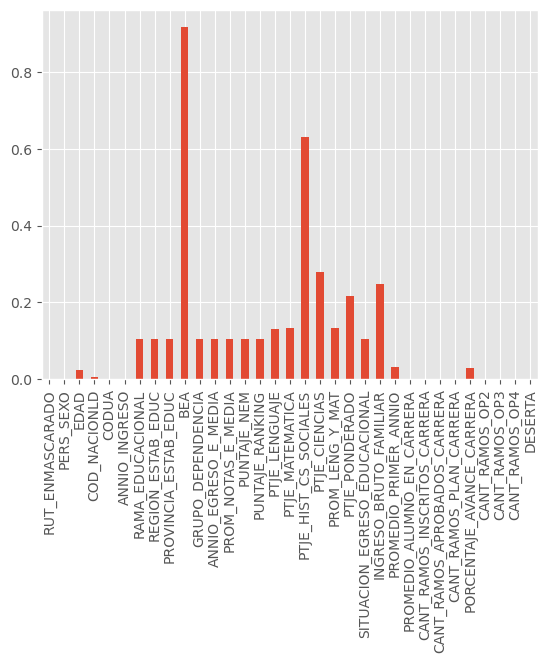

In [24]:
datos_clean2.isna().mean().plot(kind="bar")

157

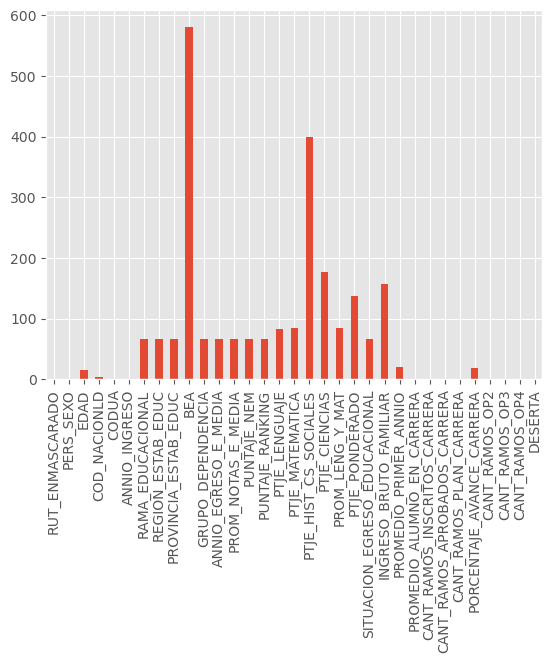

In [26]:
datos_clean2.isna().sum().plot(kind="bar")
datos_clean2["INGRESO_BRUTO_FAMILIAR"].isna().sum()

## Transformación de variables

DESERTA

In [27]:
# datos_clean2["DESERTA"] = np.where(datos_clean2["DESERTA"]==1,'Si','No')
# print(datos_clean2["DESERTA"].value_counts())
# print(datos_clean2['DESERTA'].value_counts(normalize=True))
# 14% Verdaderos 86% Falsos

CODUA

In [28]:
datos_clean2["CODUA"] = np.where(datos_clean2["CODUA"]==3353,'Ingeco','Enfermeria')
print(datos_clean2["CODUA"].value_counts())

Ingeco        342
Enfermeria    291
Name: CODUA, dtype: int64


BEA: consultar si tiene incidencia contar o no con ella. Bajo % con beca (se prueba)

In [29]:
datos_clean2["BEA"] = np.where(datos_clean2["BEA"].notnull(), "BEA", "SIN BEA")
print(datos_clean2["BEA"].value_counts(normalize=True))
print(datos_clean2["BEA"].value_counts())


SIN BEA    0.916272
BEA        0.083728
Name: BEA, dtype: float64
SIN BEA    580
BEA         53
Name: BEA, dtype: int64


EDAD

In [32]:
#from asyncio.windows_events import NULL

# datos_clean2["EDAD"] =
np.where(datos_clean2["EDAD"].notnull(), np.select(
    condlist = [datos_clean2["EDAD"] <= 23 ,
                datos_clean2["EDAD"] <= 27,
                datos_clean2["EDAD"] <= 31,
                datos_clean2["EDAD"] <= 35,
                datos_clean2["EDAD"] <= 40 ],
    choicelist = [ "Edad 17-23", "Edad 24-26", "Edad 27-30", "Edad 31-34", "Edad 35-39" ],
    default    = "Otra edad"), NA
)
#datos_clean2.query("EDAD=='Edad 17-23'")["EDAD"].count()
#print(datos_clean2["EDAD"].value_counts())


array(['Edad 17-23', 'Edad 17-23', 'Edad 35-39', 'Edad 35-39',
       'Edad 35-39', 'Edad 31-34', 'Edad 17-23', 'Edad 31-34',
       'Edad 31-34', 'Edad 27-30', 'Edad 27-30', 'Edad 27-30',
       'Edad 27-30', 'Edad 27-30', 'Edad 27-30', '', 'Edad 27-30',
       'Edad 27-30', 'Edad 27-30', 'Edad 27-30', 'Edad 27-30',
       'Edad 27-30', 'Edad 27-30', 'Edad 27-30', 'Edad 27-30',
       'Edad 27-30', 'Edad 27-30', 'Edad 27-30', 'Edad 27-30',
       'Edad 27-30', 'Edad 27-30', 'Edad 24-26', 'Edad 24-26',
       'Edad 27-30', 'Edad 24-26', 'Edad 27-30', 'Edad 24-26',
       'Edad 24-26', 'Edad 24-26', 'Edad 24-26', 'Edad 24-26',
       'Edad 24-26', 'Edad 24-26', '', 'Edad 24-26', 'Edad 24-26',
       'Edad 24-26', 'Edad 24-26', '', 'Edad 24-26', 'Edad 24-26',
       'Edad 24-26', 'Edad 24-26', 'Edad 24-26', 'Edad 24-26',
       'Edad 24-26', 'Edad 24-26', 'Edad 24-26', '', 'Edad 24-26',
       'Edad 24-26', 'Edad 24-26', 'Edad 24-26', 'Edad 24-26',
       'Edad 24-26', 'Edad 24-26', 'Eda

In [32]:
print(datos_clean2["EDAD"].value_counts())

Edad 17-23    446
Edad 24-26    139
Edad 27-30     23
nan            15
Edad 35-39      5
Edad 31-34      5
Name: EDAD, dtype: int64


INGRESO_BRUTO_FAMILIAR

In [34]:

# datos_clean2["INGRESO_BRUTO_FAMILIAR"] = np.where(datos_clean2["INGRESO_BRUTO_FAMILIAR"].notnull(), np.select( 
#     condlist   = [datos_clean2["INGRESO_BRUTO_FAMILIAR"] == 1.0, \
#                   datos_clean2["INGRESO_BRUTO_FAMILIAR"] == 2.0, 
#                   datos_clean2["INGRESO_BRUTO_FAMILIAR"] == 3.0,
#                   datos_clean2["INGRESO_BRUTO_FAMILIAR"] == 4.0,
#                   datos_clean2["INGRESO_BRUTO_FAMILIAR"] == 5.0,
#                   datos_clean2["INGRESO_BRUTO_FAMILIAR"] == 6.0,
#                   datos_clean2["INGRESO_BRUTO_FAMILIAR"] == 7.0,
#                   datos_clean2["INGRESO_BRUTO_FAMILIAR"] == 8.0,
#                   datos_clean2["INGRESO_BRUTO_FAMILIAR"] == 9.0,
#                   datos_clean2["INGRESO_BRUTO_FAMILIAR"] == 10.0 ],
#     # choicelist = ["1º decil", "2º decil", "3º decil", "4º decil", "5º decil",
#     #               "6º decil", "7º decil", "8º decil", "9º decil", "10º decil"],
#     choicelist = [1.0, 2.0, 3.0, 4.0, 5.0,
#                     6.0, 7.0, 8.0, 9.0, 10.0],
#     default    = "Otro decil" ), datos_clean2["INGRESO_BRUTO_FAMILIAR"]
# )

# print(datos_clean2["INGRESO_BRUTO_FAMILIAR"].value_counts())


COD_NACIONLD: la mayoría es chileno, poca incidencia, se elimina variable

In [35]:
datos_clean2["COD_NACIONLD"] = np.where(datos_clean2["COD_NACIONLD"].notnull(),
                                        np.where(datos_clean2["COD_NACIONLD"]==1,"Chileno","Extranjero"),
                                        np.NaN)
print(datos_clean2["COD_NACIONLD"].value_counts())   
# Chileno       602
# Extranjero     27

# se elimina variable
datos_clean2 = datos_clean2.drop("COD_NACIONLD", axis=1)                                

Chileno       602
Extranjero     27
nan             4
Name: COD_NACIONLD, dtype: int64


REGION_ESTAB_EDUC: La mayoría de Reg. Antof, poca incidencia. Se elimina variable

In [36]:
datos_clean2["REGION_ESTAB_EDUC"] = np.where(datos_clean2["REGION_ESTAB_EDUC"].notnull(),
                                        np.where(datos_clean2["REGION_ESTAB_EDUC"]=='REGION DE ANTOFAGASTA',
                                        "REGION DE ANTOFAGASTA","OTRA REGION"),
                                        np.NaN)
print(datos_clean2["REGION_ESTAB_EDUC"].value_counts())  

# se elimina variable
datos_clean2 = datos_clean2.drop("REGION_ESTAB_EDUC", axis=1)  

REGION DE ANTOFAGASTA    531
nan                       66
OTRA REGION               36
Name: REGION_ESTAB_EDUC, dtype: int64


PROVINCIA_ESTAB_EDUC

In [37]:
#print(datos_clean2["PROVINCIA_ESTAB_EDUC"].value_counts())  
datos_clean2["PROVINCIA_ESTAB_EDUC"] = np.where(datos_clean2["PROVINCIA_ESTAB_EDUC"].notnull(),\
                                           np.where(datos_clean2["PROVINCIA_ESTAB_EDUC"]!="ANTOFAGASTA",\
                                              np.where(datos_clean2["PROVINCIA_ESTAB_EDUC"]!="EL LOA",\
                                                 np.where( datos_clean2["PROVINCIA_ESTAB_EDUC"]!="TOCOPILLA",\
                                                    "OTRA PROVINCIA", datos_clean2["PROVINCIA_ESTAB_EDUC"]),\
                                              datos_clean2["PROVINCIA_ESTAB_EDUC"]),\
                                           datos_clean2["PROVINCIA_ESTAB_EDUC"]),\
                                        np.NaN)
print(datos_clean2["PROVINCIA_ESTAB_EDUC"].value_counts())  


ANTOFAGASTA       439
EL LOA             75
OTRA PROVINCIA     36
TOCOPILLA          17
Name: PROVINCIA_ESTAB_EDUC, dtype: int64


ANNIO_EGRESO_E_MEDIA

In [39]:
datos_clean2["ANNIO_EGRESO_E_MEDIA"] = np.where(datos_clean2["ANNIO_EGRESO_E_MEDIA"].notnull(), 
                                                np.select(
                                                   condlist = [datos_clean2["ANNIO_EGRESO_E_MEDIA"]<2012.0,
                                                               datos_clean2["ANNIO_EGRESO_E_MEDIA"]<2015.0],
                                                  choicelist = [ "Egreso media 2003-2011", 
                                                                 "Egreso media 2012-2014" ], 
                                                  default    = "Egreso media 2015-2020"), 
                                                np.NaN)

print(datos_clean2["ANNIO_EGRESO_E_MEDIA"].value_counts())  


Egreso media 2015-2020    526
nan                        67
Egreso media 2012-2014     29
Egreso media 2003-2011     11
Name: ANNIO_EGRESO_E_MEDIA, dtype: int64


SITUACION_EGRESO_EDUCACIONAL

In [40]:
datos_clean2["SITUACION_EGRESO_EDUCACIONAL"] = np.where(datos_clean2["SITUACION_EGRESO_EDUCACIONAL"].notnull(), 
                                               np.select(
                                                condlist = [datos_clean2["SITUACION_EGRESO_EDUCACIONAL"]==1,
                                                            datos_clean2["SITUACION_EGRESO_EDUCACIONAL"]==3,
                                                            datos_clean2["SITUACION_EGRESO_EDUCACIONAL"]==4,
                                                            datos_clean2["SITUACION_EGRESO_EDUCACIONAL"]==5],
                                                choicelist = [ "Prom.Año: Nac–alumno regular", 
                                                               "Prom.Año: Extr–con algún curso en Chile",
                                                               "Prom.Año: Extr–no acredita notas",
                                                               "Prom.Ant: Nac–alumno regular"], 
                                                default    = "Otra situacion"), 
                                               np.NaN)

print(datos_clean2["SITUACION_EGRESO_EDUCACIONAL"].value_counts())  
#Prom.Año: Nac–alumno regular     395
#Prom.Ant: Nac–alumno regular     169
#nan                               67
#Prom.Ant: Nac–valid. estudios      1
#Prom.Año: Nac–valid. estudios      1

# estos ultimos 2 los transforme en 'Otra situacion'


Prom.Año: Nac–alumno regular    395
Prom.Ant: Nac–alumno regular    169
nan                              67
Otra situacion                    2
Name: SITUACION_EGRESO_EDUCACIONAL, dtype: int64


LUGAR_LISTA: eliminado, no dice mucho

In [41]:
from cmath import isnan
from math import nan

#cantidad de NA
#datos_clean2.isna().sum()
#datos_clean2["LUGAR_LISTA"].isna().sum()

#print(datos_clean2["LUGAR_LISTA"].value_counts())   
# 93 casos = 0
# 66 casos nulos

# datos_clean2["LUGAR_LISTA"] = np.where(datos_clean2["LUGAR_LISTA"].notnull(), 
#                                                np.select(
#                                                 condlist = [datos_clean2["LUGAR_LISTA"]==0,
#                                                             datos_clean2["LUGAR_LISTA"]<30,
#                                                             datos_clean2["LUGAR_LISTA"]<60,
#                                                             datos_clean2["LUGAR_LISTA"]<90,
#                                                             datos_clean2["LUGAR_LISTA"]<120 ],
#                                                 choicelist = [ nan, 
#                                                                "G1 Lista",
#                                                                "G2 Lista",
#                                                                "G3 Lista",
#                                                                "G4 Lista"], 
#                                                 default    = "G5 lista"), 
#                                                datos_clean2["LUGAR_LISTA"] )

# print(datos_clean2["LUGAR_LISTA"].value_counts())  


# 159 NA


GRUPO_DEPENDENCIA

In [42]:
datos_clean2["GRUPO_DEPENDENCIA"] = np.where(datos_clean2["GRUPO_DEPENDENCIA"].notnull(), 
                                               np.select(
                                                condlist = [datos_clean2["GRUPO_DEPENDENCIA"]==1,
                                                            datos_clean2["GRUPO_DEPENDENCIA"]==2,
                                                            datos_clean2["GRUPO_DEPENDENCIA"]==3 ],
                                                choicelist = [ "Particular Pagado", 
                                                               "Particular Subvencionado",
                                                               "Municipal" ], 
                                                default    = "Servicio Local de Educacion"), 
                                               np.NaN)

print(datos_clean2["GRUPO_DEPENDENCIA"].value_counts())  


Particular Subvencionado       277
Municipal                      210
Particular Pagado               75
nan                             67
Servicio Local de Educacion      4
Name: GRUPO_DEPENDENCIA, dtype: int64


In [43]:
# Eliminación RUT enmascarado
# datos_clean2 = datos_clean2.drop(columns=["RUT_ENMASCARADO"])
# datos_clean2.info()


Limpia los NAs despues de trasformar variables

In [44]:
datos_clean2['PUNTAJE_RANKING'].mean()

636.5097001763669

In [45]:
datosclean3=datos_clean2

In [46]:
datos_clean2.isna().sum()

RUT_ENMASCARADO                   0
PERS_SEXO                         0
EDAD                              0
CODUA                             0
ANNIO_INGRESO                     0
RAMA_EDUCACIONAL                 67
PROVINCIA_ESTAB_EDUC             66
BEA                               0
GRUPO_DEPENDENCIA                 0
ANNIO_EGRESO_E_MEDIA              0
PROM_NOTAS_E_MEDIA               67
PUNTAJE_NEM                      66
PUNTAJE_RANKING                  66
PTJE_LENGUAJE                    83
PTJE_MATEMATICA                  84
PTJE_HIST_CS_SOCIALES           399
PTJE_CIENCIAS                   176
PROM_LENG_Y_MAT                  84
PTJE_PONDERADO                  138
SITUACION_EGRESO_EDUCACIONAL      0
INGRESO_BRUTO_FAMILIAR          157
PROMEDIO_PRIMER_ANNIO            21
PROMEDIO_ALUMNO_EN_CARRERA        0
CANT_RAMOS_INSCRITOS_CARRERA      0
CANT_RAMOS_APROBADOS_CARRERA      0
CANT_RAMOS_PLAN_CARRERA           0
PORCENTAJE_AVANCE_CARRERA        18
CANT_RAMOS_OP2              

In [40]:
#Completa los NA's
d=datos_clean2.fillna({'RAMA_EDUCACIONAL': "H1",
              'EDAD': "Edad 17-23",
              'REGION_ESTAB_EDUC': 'REGION DE ANTOFAGASTA',
              'PROVINCIA_ESTAB_EDUC': 'ANTOFAGASTA',
              'GRUPO_DEPENDENCIA': 'Particular Subvencionado',
              'ANNIO_EGRESO_E_MEDIA': 'Egreso media 2015-2020',
              'PROMEDIO_PRIMER_ANNIO': datos_clean2['PROMEDIO_PRIMER_ANNIO'].mean(),
              'PROM_NOTAS_E_MEDIA': datos_clean2['PROM_NOTAS_E_MEDIA'].mean(),
              'PUNTAJE_NEM': datos_clean2['PUNTAJE_NEM'].mean(),
              'PUNTAJE_RANKING': datos_clean2['PUNTAJE_RANKING'].mean(),
              'PTJE_LENGUAJE': datos_clean2['PTJE_LENGUAJE'].mean(),
              'PTJE_MATEMATICA': datos_clean2['PTJE_MATEMATICA'].mean(),
              'PROM_LENG_Y_MAT': datos_clean2['PROM_LENG_Y_MAT'].mean(),
              'PTJE_PONDERADO': datos_clean2['PTJE_PONDERADO'].mean(),
              'PTJE_CIENCIAS': datos_clean2['PTJE_CIENCIAS'].mean(),
              'SITUACION_EGRESO_EDUCACIONAL': 'Prom.Año: Nac–alumno regular',
              'INGRESO_BRUTO_FAMILIAR': 2.0,
             #'PORCENTAJE_AVANCE_CARRERA': datos_clean2['PORCENTAJE_AVANCE_CARRERA'].median(),\
             'PTJE_HIST_CS_SOCIALES': datos_clean2['PTJE_HIST_CS_SOCIALES'].mean(),
            'PROMEDIO_ALUMNO_EN_CARRERA': datos_clean2['PTJE_HIST_CS_SOCIALES'].mean()
               })  



In [44]:
datos_clean2["EDAD"].isna().sum()

0

In [52]:
d[d["RUT_ENMASCARADO"]==18289782]["EDAD"] is np.number

False

In [62]:
e=datos_clean2.fillna({'EDAD': "Edad 17-23"})

In [33]:
PorcePromAnioIngreso = datos_clean2.groupby("ANNIO_INGRESO").mean()["PORCENTAJE_AVANCE_CARRERA"]
display(PorcePromAnioIngreso)
datos_clean2["PORCENTAJE_AVANCE_CARRERA"]=np.where((datos_clean2["PORCENTAJE_AVANCE_CARRERA"].isna()), PorceAvance["PORCENTAJE_AVANCE_CARRERA"], datos_clean2["PORCENTAJE_AVANCE_CARRERA"])

ANNIO_INGRESO
2017    70.706988
2018    62.772061
2019    47.511475
2020    34.162626
2021    19.164536
Name: PORCENTAJE_AVANCE_CARRERA, dtype: float64

NameError: name 'PorceAvance' is not defined

2da Visualización de NA

In [ ]:
datos_clean2["INGRESO_BRUTO_FAMILIAR"]

0       2º decil
4       2º decil
7            nan
11           nan
12           nan
          ...   
2069         nan
2070    4º decil
2072    3º decil
2074         nan
2075         nan
Name: INGRESO_BRUTO_FAMILIAR, Length: 731, dtype: object

<AxesSubplot:>

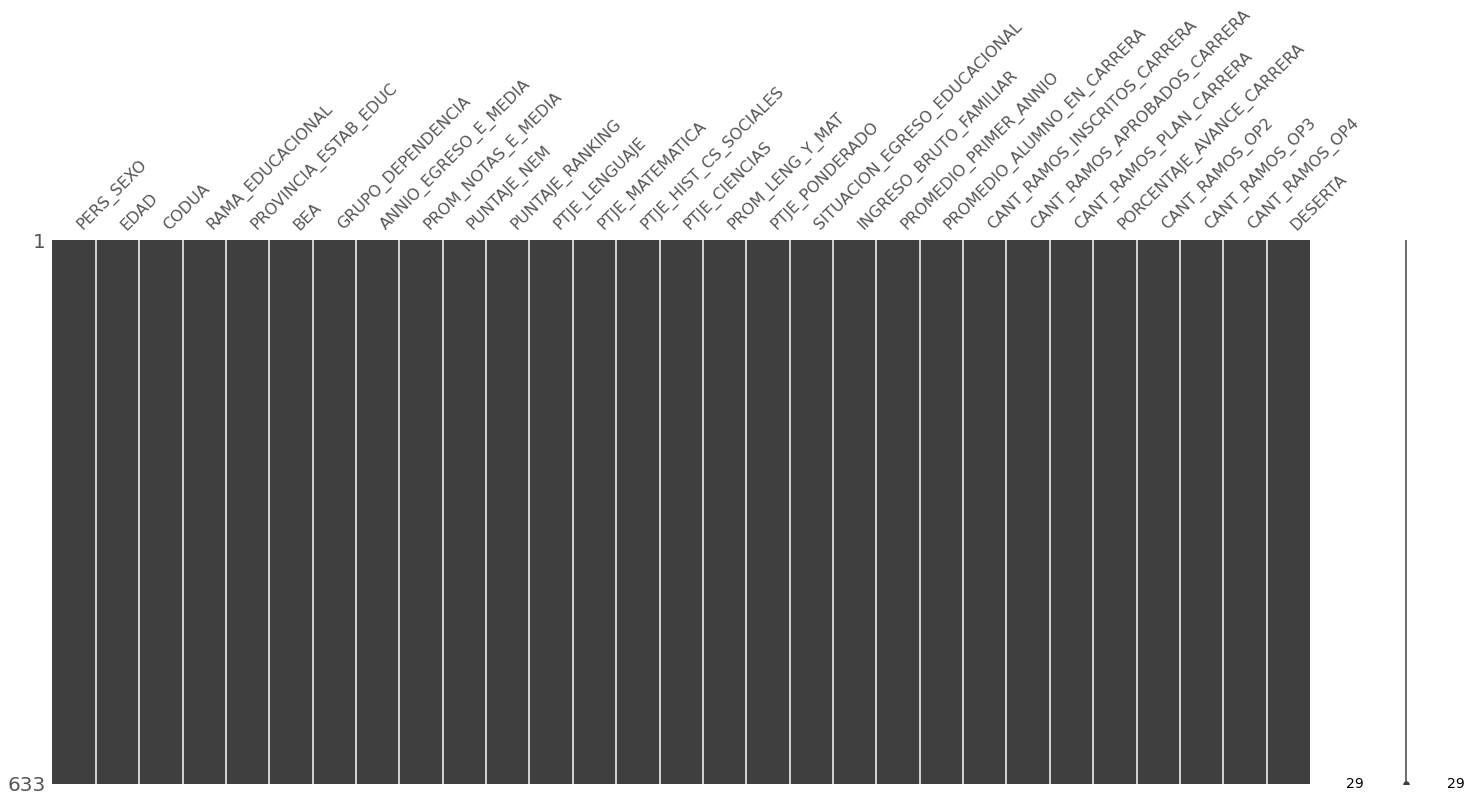

In [ ]:
msngo.matrix(datos_clean2)

Análisis Descriptivo

In [ ]:
# análisis descriptivo de variables numericas
datos_clean2.describe(datetime_is_numeric=True).T

#     CANT_RAMOS_OP4	media=	0.036335  se podría eliminar

,count,mean,std,min,25%,50%,75%,max
PROM_NOTAS_E_MEDIA,633.0,5.843410,0.481377,4.00,5.500000,5.880000,6.200000,6.90
PUNTAJE_NEM,633.0,605.292769,98.692171,374.00,528.000000,605.292769,686.000000,829.00
PUNTAJE_RANKING,633.0,636.509700,122.355454,374.00,537.000000,636.509700,736.000000,850.00
PTJE_LENGUAJE,633.0,534.998182,79.376596,273.00,491.000000,534.998182,582.000000,773.00
PTJE_MATEMATICA,633.0,540.859745,75.808159,212.00,507.000000,540.859745,591.000000,719.00
PTJE_HIST_CS_SOCIALES,633.0,522.739316,68.126245,210.00,522.739316,522.739316,522.739316,850.00
PTJE_CIENCIAS,633.0,529.039387,77.648442,257.00,501.000000,529.039387,576.000000,727.00
PROM_LENG_Y_MAT,633.0,538.013661,69.311575,258.50,498.000000,538.013661,584.500000,728.00
PTJE_PONDERADO,633.0,599.080808,78.928693,424.00,537.000000,599.080808,647.000000,914.00
PROMEDIO_PRIMER_ANNIO,633.0,4.962958,1.040447,1.00,4.580000,5.240000,5.660000,6.38


In [ ]:
# descripcion variables categoricas
datos_clean2.describe(include="object")

,PERS_SEXO,EDAD,CODUA,RAMA_EDUCACIONAL,PROVINCIA_ESTAB_EDUC,BEA,GRUPO_DEPENDENCIA,ANNIO_EGRESO_E_MEDIA,SITUACION_EGRESO_EDUCACIONAL,INGRESO_BRUTO_FAMILIAR
count,633,633,633,633,633,633,633,633,633,633
unique,2,6,2,6,4,2,5,4,4,12
top,F,Edad 17-23,Ingeco,H1,ANTOFAGASTA,SIN BEA,Particular Subvencionado,Egreso media 2015-2020,Prom.Año: Nac–alumno regular,nan
freq,395,338,342,500,505,580,277,526,395,157


Análisis de la variable respuesta

In [ ]:
print(pd.crosstab(index=datos_clean2['DESERTA'], columns='count'))
print(datos_clean2['DESERTA'].value_counts(normalize=True))

col_0    count
DESERTA       
0          543
1           90
0    0.85782
1    0.14218
Name: DESERTA, dtype: float64


Text(0, 0.5, 'N° de Observaciones')

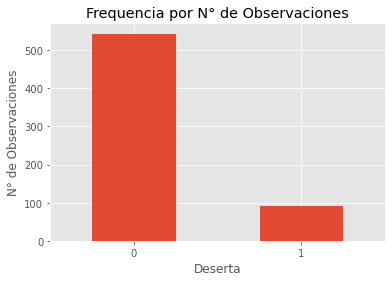

In [ ]:
#datos_clean2["DESERTA"]
#datos_clean2.mean('DESERTA')

count_classes = pd.value_counts(datos_clean2['DESERTA'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
#plt.xticks(range(2), LABELS)
plt.title("Frequencia por N° de Observaciones")
plt.xlabel("Deserta")
plt.ylabel("N° de Observaciones")

## Revisa correlación

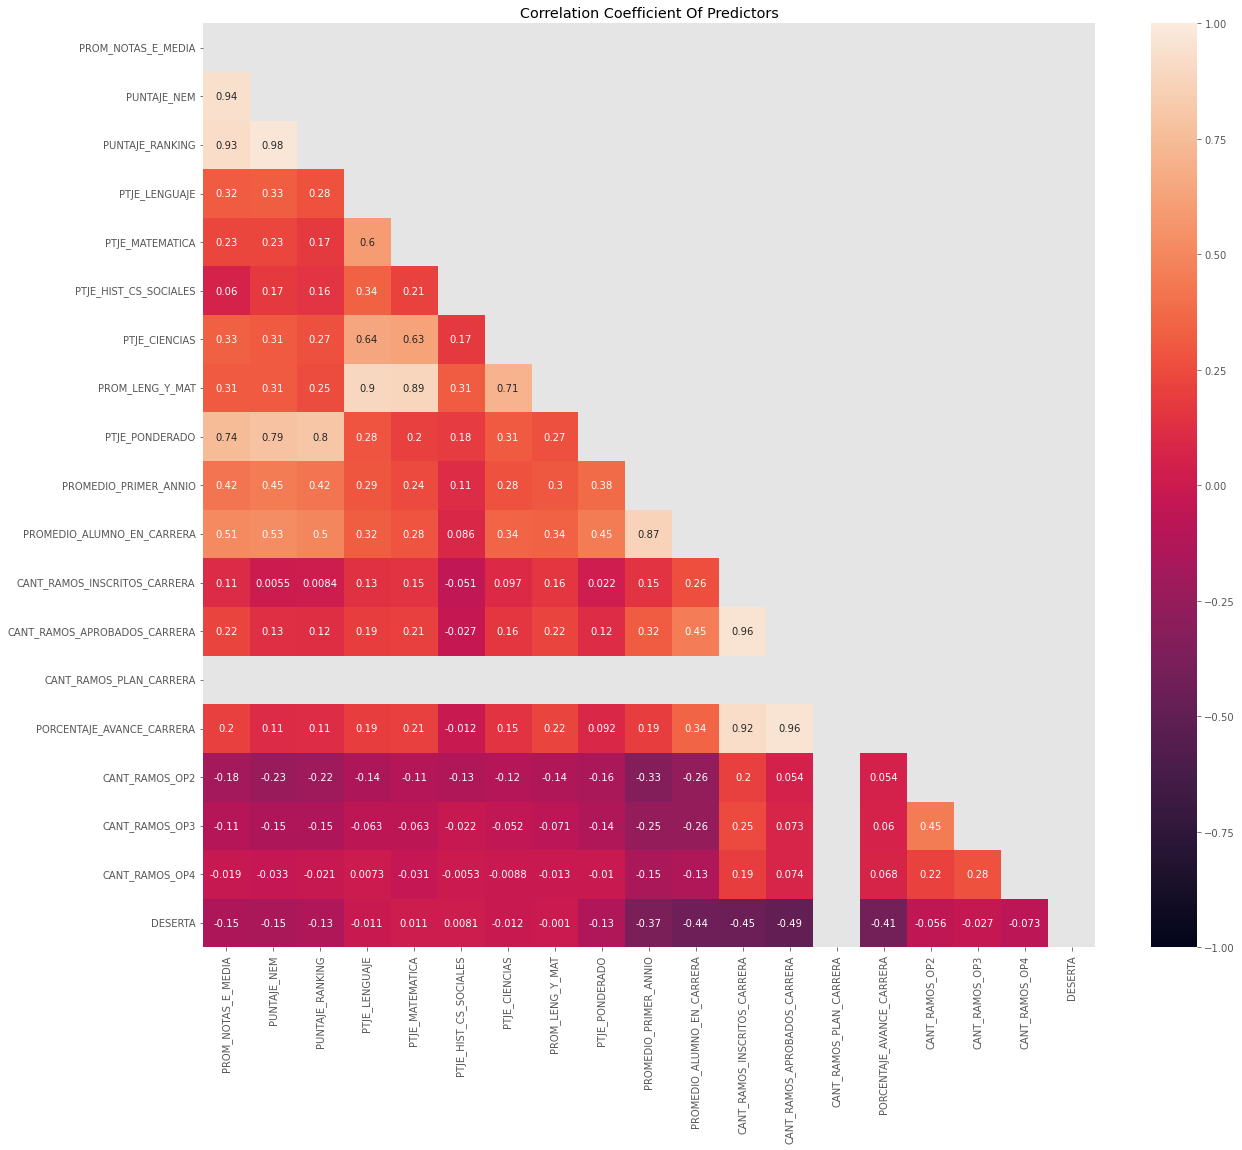

In [ ]:
# set figure size
plt.figure(figsize=(20,17))

# Generate a mask to onlyshow the bottom triangle
mask = np.triu(np.ones_like(datos_clean2.corr(), dtype=bool))

# generate heatmap
sns.heatmap(datos_clean2.corr(), annot=True, mask=mask, vmin=-1, vmax=1)
plt.title('Correlation Coefficient Of Predictors')
plt.show()

In [ ]:
# load statmodels functions
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# compute the vif for all given features
def compute_vif(considered_features):
    
    X = datos_clean2[considered_features]
    # the calculation of variance inflation requires a constant
    X['intercept'] = 1
    
    # create dataframe to store vif values
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif[vif['Variable']!='intercept']
    return vif

In [ ]:
# features to consider removing
considered_features = ['CANT_RAMOS_INSCRITOS_CARRERA',\
        'PTJE_PONDERADO','PROM_NOTAS_E_MEDIA', \
       'PTJE_MATEMATICA','PTJE_LENGUAJE', 'PTJE_CIENCIAS',\
     'PROMEDIO_PRIMER_ANNIO', 'PROMEDIO_ALUMNO_EN_CARRERA' ]

# Eliminar por alta correlación
# 'PROM_LENG_Y_MAT','CANT_RAMOS_APROBADOS_CARRERA','PUNTAJE_NEM', 'PUNTAJE_RANKING' , 'PORCENTAJE_AVANCE_CARRERA',\
# compute vif ( vif>5 Sacar de a una variable)
compute_vif(considered_features).sort_values('VIF', ascending=False)


,Variable,VIF
7,PROMEDIO_ALUMNO_EN_CARRERA,4.985214
6,PROMEDIO_PRIMER_ANNIO,4.207891
2,PROM_NOTAS_E_MEDIA,2.484866
1,PTJE_PONDERADO,2.314458
5,PTJE_CIENCIAS,2.122529
4,PTJE_LENGUAJE,1.971091
3,PTJE_MATEMATICA,1.869975
0,CANT_RAMOS_INSCRITOS_CARRERA,1.131855


Eliminar variables con alta correlación

In [ ]:
datos_clean2 = datos_clean2.drop(columns=["PROM_LENG_Y_MAT"])
datos_clean2 = datos_clean2.drop(columns=["PUNTAJE_RANKING"])
datos_clean2 = datos_clean2.drop(columns=["PUNTAJE_NEM"])
datos_clean2 = datos_clean2.drop(columns=["PORCENTAJE_AVANCE_CARRERA"])
datos_clean2 = datos_clean2.drop(columns=["CANT_RAMOS_APROBADOS_CARRERA"])

datos_clean2 = datos_clean2.drop(columns=["CANT_RAMOS_PLAN_CARRERA"]) # no es significante 1 sola categoria

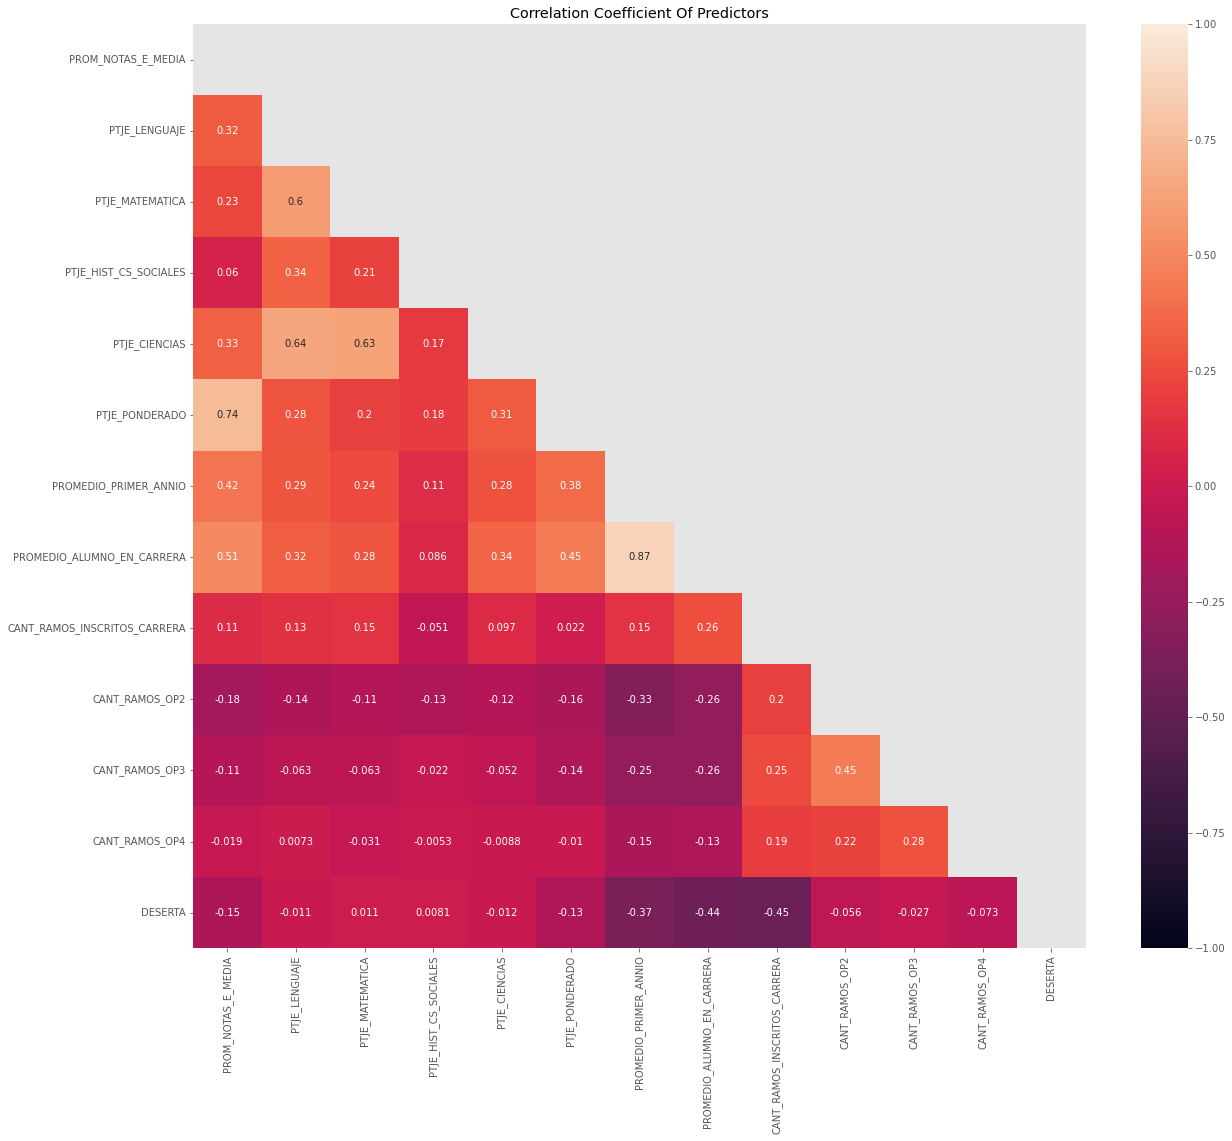

In [ ]:
# set figure size
plt.figure(figsize=(20,17))

# Generate a mask to onlyshow the bottom triangle
mask = np.triu(np.ones_like(datos_clean2.corr(), dtype=bool))

# generate heatmap
sns.heatmap(datos_clean2.corr(), annot=True, mask=mask, vmin=-1, vmax=1)
plt.title('Correlation Coefficient Of Predictors')
plt.show()

## Variables relevantes

In [ ]:

datos_clean2.columns.values.tolist()

['PERS_SEXO',
 'EDAD',
 'CODUA',
 'RAMA_EDUCACIONAL',
 'PROVINCIA_ESTAB_EDUC',
 'BEA',
 'GRUPO_DEPENDENCIA',
 'ANNIO_EGRESO_E_MEDIA',
 'PROM_NOTAS_E_MEDIA',
 'PTJE_LENGUAJE',
 'PTJE_MATEMATICA',
 'PTJE_HIST_CS_SOCIALES',
 'PTJE_CIENCIAS',
 'PTJE_PONDERADO',
 'SITUACION_EGRESO_EDUCACIONAL',
 'INGRESO_BRUTO_FAMILIAR',
 'PROMEDIO_PRIMER_ANNIO',
 'PROMEDIO_ALUMNO_EN_CARRERA',
 'CANT_RAMOS_INSCRITOS_CARRERA',
 'CANT_RAMOS_OP2',
 'CANT_RAMOS_OP3',
 'CANT_RAMOS_OP4',
 'DESERTA']